In [24]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import IPython.display
import pickle
import os
from tqdm import tqdm
import collections
import json
import torch
import torch.nn.functional as F
import sys
import numpy as np


sys.path.append('..')
from src.train import Trainer
from src.utils import set_requires_grad
from clsmodel import mnist, stl10, afhq

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# load exp config
model_path = '/vol/biomedic2/agk21/PhDLogs/codes/SYB3/LOGS/MNIST/models/best.pth'

#data-folder-path
folder_path = '/vol/biomedic2/agk21/PhDLogs/datasets/MNIST'
# folder_path = '/vol/biomedic2/agk21/PhDLogs/datasets/AFHQ/afhq'

config = json.load(open(os.path.join(os.path.dirname(os.path.dirname(model_path)), 'exp-config.json'), 'r'))

# config['classifier'] = afhq(32, True).cuda(0)
config['classifier'] = mnist(32, 'it').cuda(0)

model = Trainer(**config)
model.load_model(model_path)
model.eval()


# model defns
feature_extractor = model.feature_extractor
conti_classifier = model.classifier_baseline
dis_classifier = model.classifier_quantized
decoder = model.dec
codebook_sampler = model.modelclass


# set_requires_grad(classifier, False)
set_requires_grad(feature_extractor, False)
set_requires_grad(conti_classifier, False)
set_requires_grad(dis_classifier, False)
set_requires_grad(decoder, False)
set_requires_grad(codebook_sampler, False)
    

# required config variables 
image_size = model.input_size
latent_dim = model.latent_size
num_classes = model.nclasses

Building data loader with 16 workers
True
3 2 2 2
FeatureExtractor: Total number of trainable params: 0/28640
ContiClassifier: Total number of trainable params: 0/10250
codebook: Total number of trainable params: 87881/87881
DisClassifier: Total number of trainable params: 650/650
Decoder: Total number of trainable params: 5645571/5645571
Model loaded from /vol/biomedic2/agk21/PhDLogs/codes/SYB3/LOGS/MNIST/models/best.pth, loaded epoch:9 with stats: {'loss': 1.7507538, 'f1': 0.9922, 'acc': 0.9922, 'rloss': 0.010639977}


In [31]:
from src.dataset import get

batch_size = 16
train_loader, test_loader = get(batch_size, 
                      data_root = folder_path, 
                      train=True, val=True, 
                      input_size = image_size,
                      num_workers=10)


orig_images = []; orig_labels = []
for (img_batch, label_batch, *context_batch) in tqdm(test_loader):
    img_batch = img_batch.cuda(0)
    label_batch = label_batch.cuda(0)
    orig_images.extend(img_batch)
    orig_labels.extend(label_batch)


labels_ = np.array([lb.cpu().numpy() for lb in orig_labels])
# generate sample dataset
def get_sample_data(N_datapoints = 10): 
    sample_images = []; sample_labels = []
    for ci in range(num_classes):
        idxs = np.where(labels_ == ci)[0]
        randidxs = idxs[np.random.randint(0, len(idxs), N_datapoints//num_classes)]

        for idx in randidxs:
            sample_images.append(orig_images[idx].unsqueeze(0))
            sample_labels.append(orig_labels[idx].unsqueeze(0))

    sample_images = torch.cat(sample_images, dim = 0)
    sample_labels = torch.cat(sample_labels, dim = 0)
    return sample_images, sample_labels

Building data loader with 10 workers


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:03<00:00, 188.67it/s]


OSError: [Errno 28] No space left on device: 'global-tree.png'

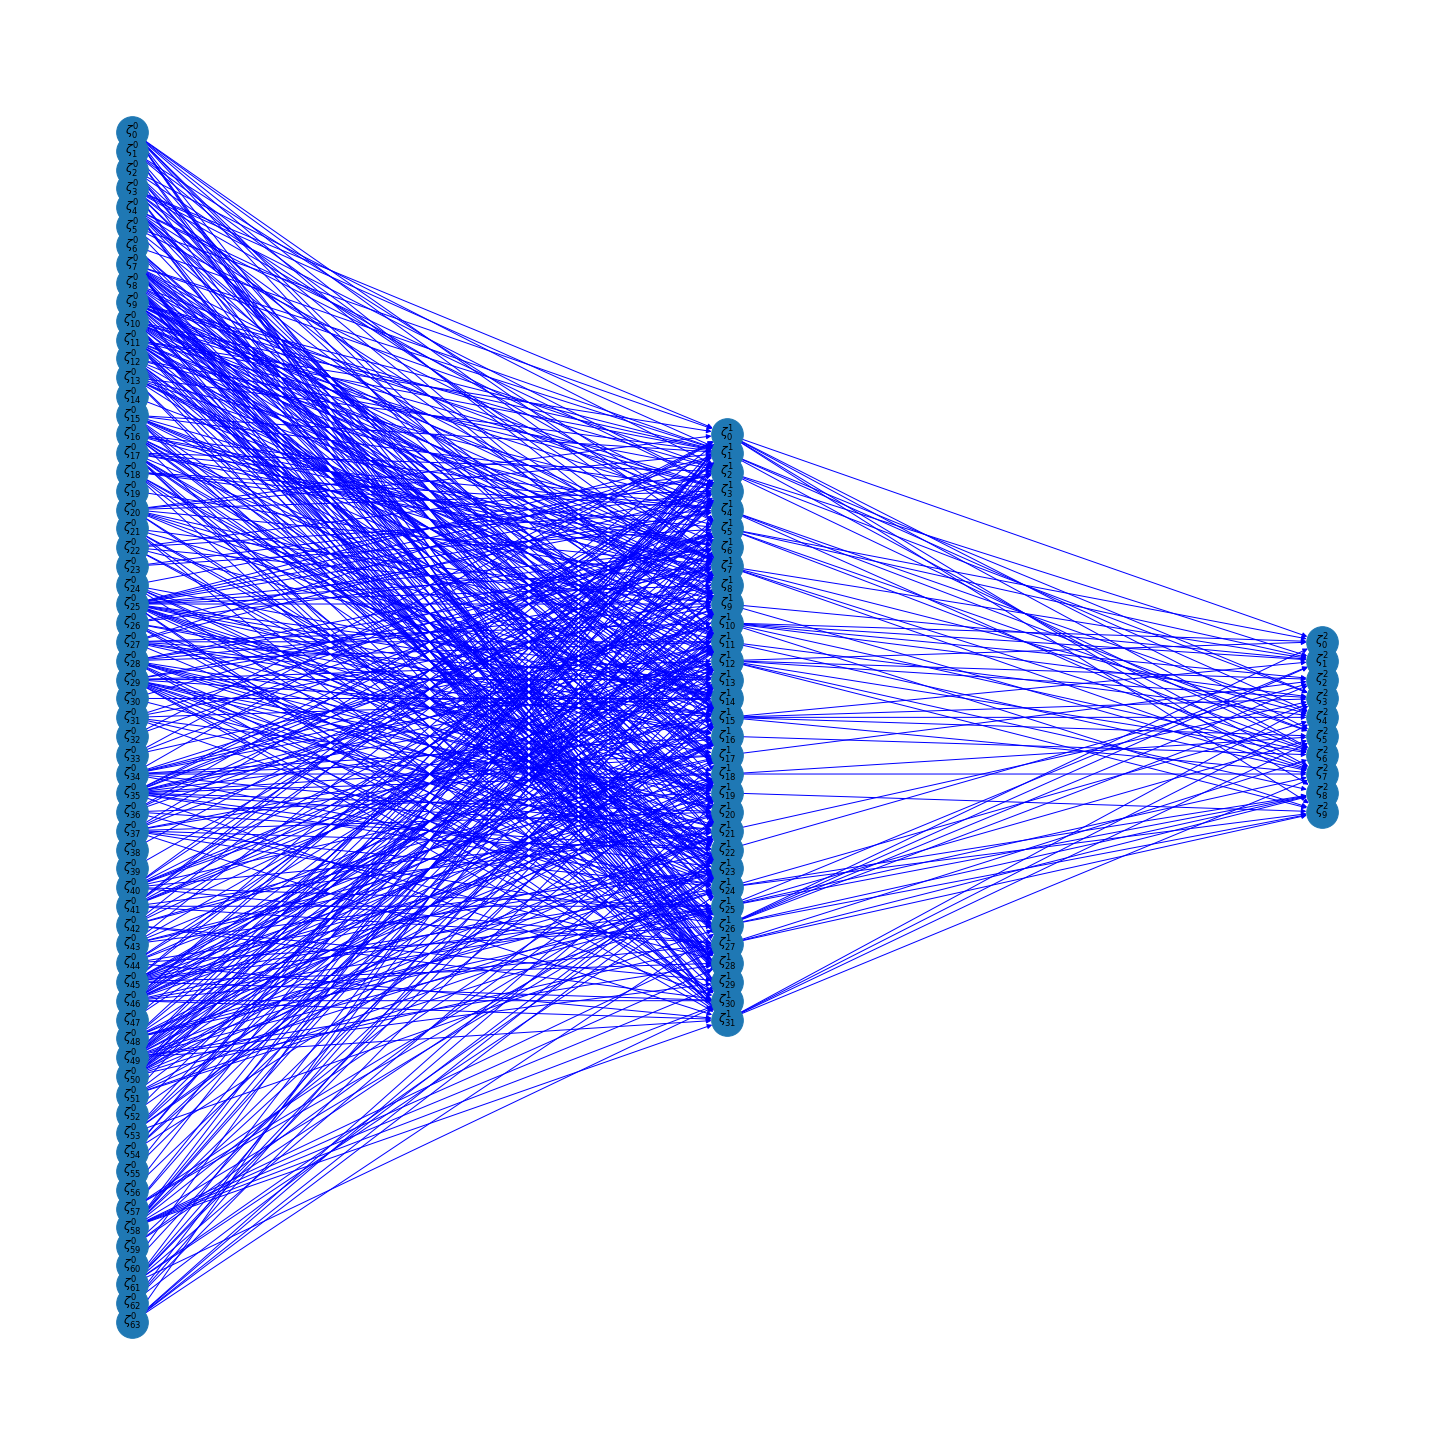

In [32]:
from src.inference import InductiveReasoningDT

inferer = InductiveReasoningDT(get_sample_data(100),
                               ncodebook_features = model.codebook_size,
                               nclasses = num_classes,
                               train_loader = train_loader,
                               feature_extractor = feature_extractor,
                               codebook = codebook_sampler,
                               classifier = dis_classifier,
                               decoder = decoder)

                               

In [ ]:
codebook_sampler.reasoningLayers[0].weight

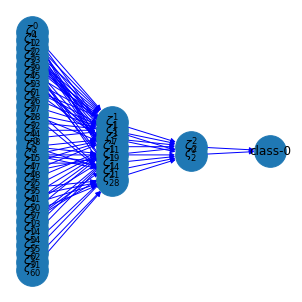

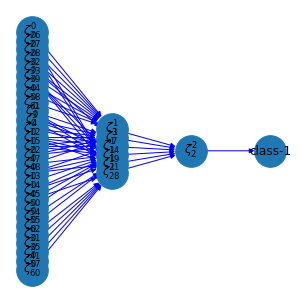

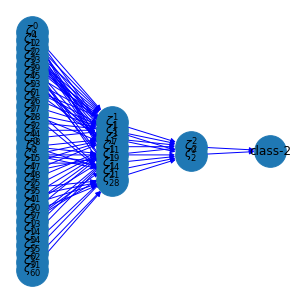

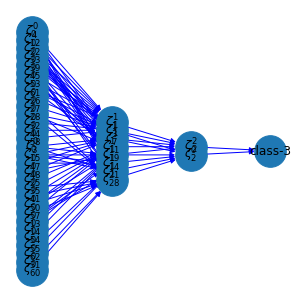

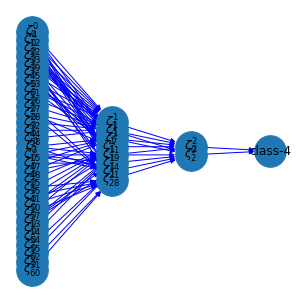

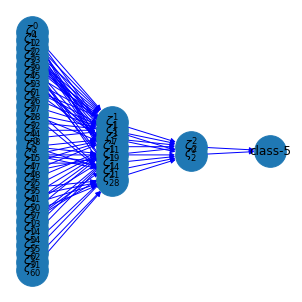

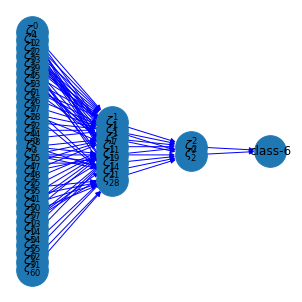

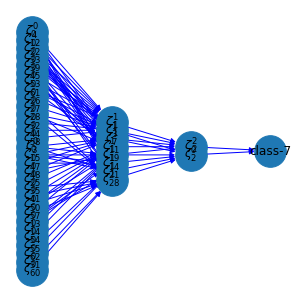

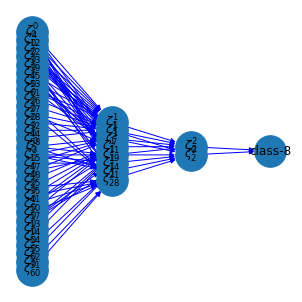

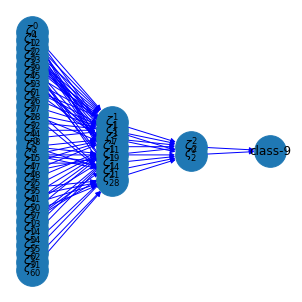

In [33]:
for ci in range(num_classes):
    inferer.get_class_tree(ci,f'/vol/biomedic3/agk21/MNISTLOGS/class-{ci}')

$\zeta^{2}_{0}$ ['$\\zeta^{1}_{1}$', '$\\zeta^{1}_{3}$', '$\\zeta^{1}_{7}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$'] [ 8 12 13 19 20 21 22 27 31]
$\zeta^{2}_{2}$ ['$\\zeta^{1}_{3}$', '$\\zeta^{1}_{7}$', '$\\zeta^{1}_{14}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\\zeta^{1}_{28}$'] [ 8 12 13 19 20 21 22 27 31]
$\zeta^{1}_{19}$ ['$\\zeta^{0}_{3}$', '$\\zeta^{0}_{13}$', '$\\zeta^{0}_{14}$', '$\\zeta^{0}_{15}$', '$\\zeta^{0}_{22}$', '$\\zeta^{0}_{39}$', '$\\zeta^{0}_{45}$', '$\\zeta^{0}_{48}$', '$\\zeta^{0}_{50}$', '$\\zeta^{0}_{54}$'] [ 0  1  2  4  7 12 13 15 20 22 25 27 28 29 31 33 38 41 44 45 46 47 48 50
 51 53 55 57 59 63]
$\zeta^{1}_{19}$ ['$\\zeta^{0}_{3}$', '$\\zeta^{0}_{13}$', '$\\zeta^{0}_{14}$', '$\\zeta^{0}_{15}$', '$\\zeta^{0}_{22}$', '$\\zeta^{0}_{39}$', '$\\zeta^{0}_{45}$', '$\\zeta^{0}_{48}$', '$\\zeta^{0}_{50}$', '$\\zeta^{0}_{54}$'] [ 0  1  2  4  7 12 13 15 20 22 25 27 28 29 31 33 38 41 44 45 46 47 48 50
 51 53 55 57 59 63]
$\zeta^{1}_{21}$ ['$\\zeta^{0}_{3}$', '$\\

OSError: [Errno 28] No space left on device: './local-tree.png'

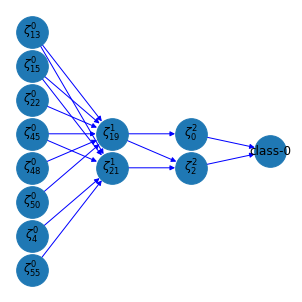

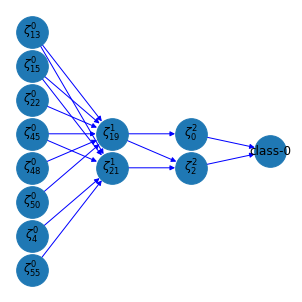

In [34]:
for ci in range(num_classes):
    
    for i in range(10):
        x,y = get_sample_data(num_classes)
        x = x[ci].unsqueeze(0)

        inferer.get_local_tree(ci, x, f'/vol/biomedic3/agk21/MNISTLOGS/class-{ci}/img{i}')
        inferer.query(ci, visual = x, local=True, overlay=True, save_path=f'/vol/biomedic3/agk21/MNISTLOGS/class-{ci}/img{i}')